In [9]:
# Ignore warnings to prevent
# UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
import warnings
warnings.filterwarnings("ignore")

from models.ml_basic_inference import predict_custom_input
from models.ml_sequential_inference import predict_custom_input_sequential
import matplotlib.pyplot as plt

female = 0
age = 70
height = 170
mass = 70
ta_set = 35
rh_set = 45

In [2]:
import jos3
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

def run_takahashi(female, age, height, mass, ta_set, rh_set, time_steps=540):
    # Scale units
    height = height / 100 # height from cm to m

    clo_females = 0.23
    clo_males = 0.15
    PAR = 1.2
    Va = 0.1

    # Get parameters
    sex = 'female' if female else 'male'
    clo = clo_females if female else clo_males
    # Build model (individual)
    model = jos3.JOS3(height=height, weight=mass, age=age, sex=sex)
    model.Icl = clo # Clothing level
    model.PAR = PAR  # Physical activity ratio [-]
    model.posture = 'sitting'  # Whether sitting or standing ??
    # Simulate 60 minutes in air-con before entering room
    model.Ta = 23
    model.RH = 9
    model.simulate(60)
    # Environmental parameters
    model.Ta = ta_set  # Operative temperature [oC]
    model.RH = rh_set  # Relative humidity [%]
    model.Va = Va  # Air velocity [m/s]
    model.simulate(time_steps)  # Exposure time = 540 [min]
    # Extract data
    df_results = pd.DataFrame(model.dict_results())  # Make pandas.DataFrame
    core_temp = df_results.TcrPelvis.tolist()
    skin_temp = df_results.TskMean.tolist()

    return core_temp[-1], skin_temp[-1]

In [3]:
from models.ji_two_node import two_nodes_optimized
from pythermalcomfort.utilities import body_surface_area
from pythermalcomfort.psychrometrics import p_sat_torr

def run_ji(female, age, height, mass, ta_set, rh_set, time_steps=540):
    # Scale units
    height = height / 100 # height from cm to m

    clo_females = 0.23
    clo_males = 0.15
    met = 1.3
    Va = 0.1

    # Get parameters
    clo = clo_females if female else clo_males

    # Calculate
    body_area = body_surface_area(mass, height)
    Ta = ta_set  # Operative temperature [oC]
    RH = rh_set  # Relative humidity [%]
    vapor_pressure = RH * p_sat_torr(Ta) / 100

    # Simulate cool environment
    cool_ta = 23
    cool_rh = 9
    cool_pressure = cool_rh * p_sat_torr(cool_ta) / 100
    initial_cooling = two_nodes_optimized(
        tdb=cool_ta,
        tr=cool_ta,
        v=Va,
        met=met,
        clo=clo,
        vapor_pressure=cool_pressure,
        wme=0,
        body_surface_area=body_area,
        p_atmospheric=101325,
        body_position="sitting",
        body_weight=mass,
        acclimatized=True,
        length_time_simulation=60
    )

    results = two_nodes_optimized(
        tdb=Ta,
        tr=Ta,
        v=Va,
        met=met,
        clo=clo,
        vapor_pressure=vapor_pressure,
        wme=0,
        body_surface_area=body_area,
        p_atmospheric=101325,
        body_position="sitting",
        body_weight=mass,
        acclimatized=True,
        length_time_simulation=time_steps,
        initial_skin_temp=initial_cooling['skin_temp_hist'][-1],
        initial_core_temp=initial_cooling['core_temp_hist'][-1],
    )

    # Extract data
    core_temp = results['core_temp_hist']
    skin_temp = results['skin_temp_hist']

    return core_temp[-1], skin_temp[-1]

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def sensitivity_analysis_table(variable, values):
    models = ['Ridge Regression', 'GRU', 'Takahashi', 'Ji']
    model_functions = [
        (predict_custom_input,),
        (predict_custom_input_sequential,),
        (run_takahashi,),
        (run_ji,),
    ]
    results_core = {model: [] for model in models}
    results_skin = {model: [] for model in models}

    for value in values:
        for model, functions in zip(models, model_functions):
            if variable == 'female':
                args = (value, age, height, mass, ta_set, rh_set)
            elif variable == 'age':
                args = (female, value, height, mass, ta_set, rh_set)
            elif variable == 'height':
                args = (female, age, value, mass, ta_set, rh_set)
            elif variable == 'mass':
                args = (female, age, height, value, ta_set, rh_set)
            elif variable == 'ta_set':
                args = (female, age, height, mass, value, rh_set)
            elif variable == 'rh_set':
                args = (female, age, height, mass, ta_set, value)

            model_results = [func(*args) for func in functions]
            results_core[model].append(model_results[0][0])
            results_skin[model].append(model_results[0][1])

    df_core = pd.DataFrame(results_core, index=values)
    df_skin = pd.DataFrame(results_skin, index=values)

    plt.figure(figsize=(8, 6))
    sns.heatmap(df_core, cmap='coolwarm', annot=True, fmt='.2f', cbar_kws={'label': 'Final Core Temperature (°C)'})
    plt.xlabel('Model')
    plt.ylabel(variable)
    plt.title('Sensitivity Analysis - Core Temperature')
    plt.tight_layout()
    # plt.savefig(f'figures/sensitivity_{variable}_core.pdf')
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.heatmap(df_skin, cmap='coolwarm', annot=True, fmt='.2f', cbar_kws={'label': 'Final Skin Temperature (°C)'})
    plt.xlabel('Model')
    plt.ylabel(variable)
    plt.title('Sensitivity Analysis - Skin Temperature')
    plt.tight_layout()
    # plt.savefig(f'figures/sensitivity_{variable}_skin.pdf')
    plt.show()

In [85]:
from matplotlib.ticker import FixedLocator
from adjustText import adjust_text

def sensitivity_analysis(variable, values, split_subplots=False, connect_dots=False, plot_values=False):
    ax1_label_annotations = []
    ax2_label_annotations = []
    models = ['Ridge Regression', 'GRU', 'Takahashi', 'Ji']
    model_functions = [
        (predict_custom_input,),
        (predict_custom_input_sequential,),
        (run_takahashi,),
        (run_ji,),
    ]
    results = {model: [] for model in models}
    graphing_styles = [
        {'color': '#25CB00', 'marker': 'o'},
        {'color': '#0313fc', 'marker': 'o'},
        {'color': '#FF9999', 'marker': 'x'},
        {'color': '#87CC94', 'marker': 'x'}
    ]

    for value in values:
        for model, functions in zip(models, model_functions):
            if variable == 'female':
                args = (value, age, height, mass, ta_set, rh_set)
            elif variable == 'age':
                args = (female, value, height, mass, ta_set, rh_set)
            elif variable == 'height':
                args = (female, age, value, mass, ta_set, rh_set)
            elif variable == 'mass':
                args = (female, age, height, value, ta_set, rh_set)
            elif variable == 'ta_set':
                args = (female, age, height, mass, value, rh_set)
            elif variable == 'rh_set':
                args = (female, age, height, mass, ta_set, value)
            model_results = [func(*args) for func in functions]
            results[model].append(model_results)

    if split_subplots:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))
    else:
        fig, ax = plt.subplots(figsize=(6, 4))
        ax1 = ax2 = ax

    x_offset = 0.02 * (max(values) - min(values))
    y_offset = 0 * (ax1.get_ylim()[1] - ax1.get_ylim()[0])

    for i, value in enumerate(values):
        for model, graphing_style in zip(models, graphing_styles):
            for j, (tre, mtsk) in enumerate(results[model][i]):
                label = f'{model}' if i == 0 else None
                ax1.plot(value, tre, color=graphing_style['color'], marker=graphing_style['marker'], label=label)
                ax2.plot(value, mtsk, color=graphing_style['color'], marker=graphing_style['marker'])

                if plot_values:
                    ax1_label_annotations.append(ax1.text(value + x_offset, tre + y_offset, f'{tre:.2f}', ha='left', va='bottom', fontsize=8))
                    ax2_label_annotations.append(ax2.text(value + x_offset, mtsk + y_offset, f'{mtsk:.2f}', ha='left', va='bottom', fontsize=8))

                if connect_dots:
                    if i > 0:
                        prev_tre, prev_mtsk = results[model][i - 1][j]
                        ax1.plot([values[i - 1], value], [prev_tre, tre], graphing_style['color'])
                        ax2.plot([values[i - 1], value], [prev_mtsk, mtsk], graphing_style['color'])

    if variable == 'female':
        ax1.xaxis.set_major_locator(FixedLocator([0, 1]))
        ax1.set_xticklabels(['Female', 'Male'])
        ax2.xaxis.set_major_locator(FixedLocator([0, 1]))
        ax2.set_xticklabels(['Female', 'Male'])
        ax1.set_xlim(-1, 2)  # Adjust the x-axis limits
        ax2.set_xlim(-1, 2)  # Adjust the x-axis limits
    else:
        ax1.set_xlabel(variable)
        ax2.set_xlabel(variable)

    ax1.set_ylabel('Final Core Temperature (°C)')
    ax1.legend()
    ax2.set_ylabel('Final Skin Temperature (°C)')

    adjust_text(ax1_label_annotations, ax=ax1)
    adjust_text(ax2_label_annotations, ax=ax2)

    plt.tight_layout()
    plt.savefig(f'figures/sensitivity_{variable}.pdf')
    plt.show()

Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00


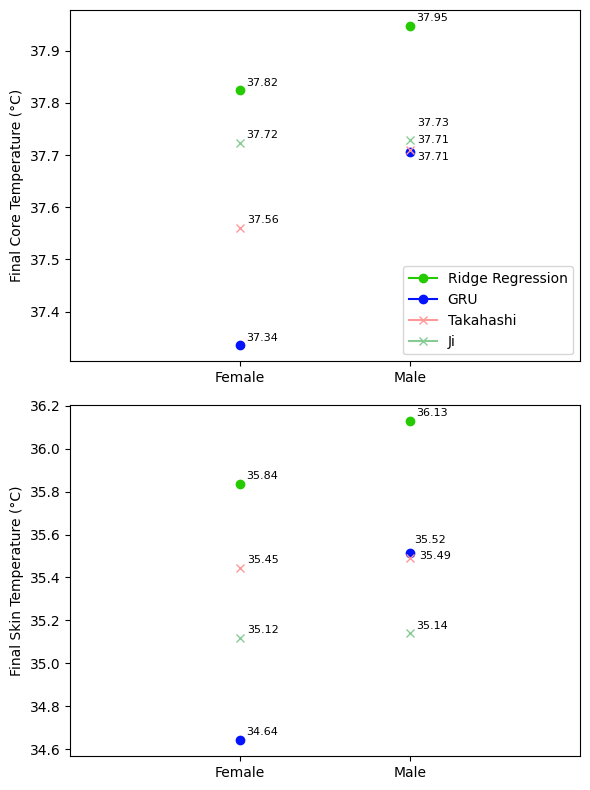

In [86]:
sensitivity_analysis('female', [0, 1], split_subplots=True, plot_values=True)

Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00


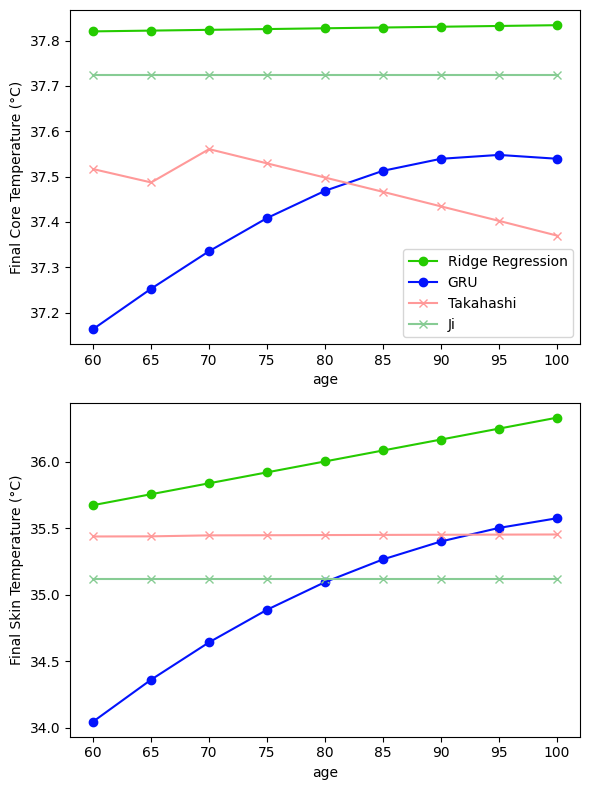

In [87]:
sensitivity_analysis('age', [60, 65, 70, 75, 80, 85, 90, 95, 100], split_subplots=True, connect_dots=True, plot_values=False)

Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00


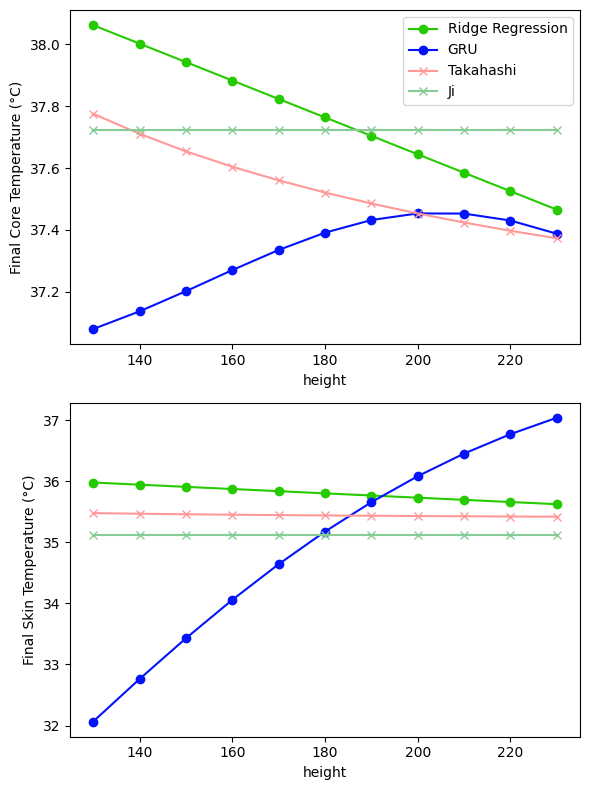

In [88]:
sensitivity_analysis('height', [130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230], split_subplots=True, connect_dots=True, plot_values=False)

Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00


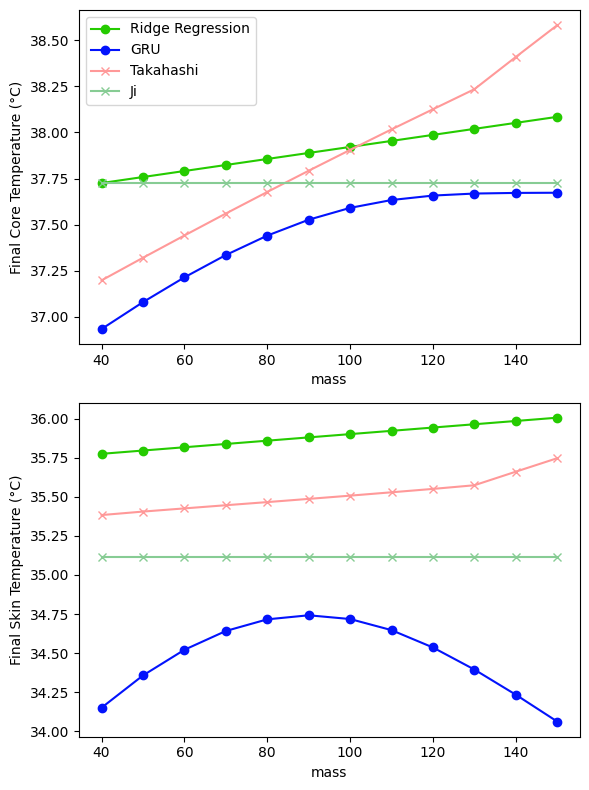

In [89]:
sensitivity_analysis('mass', [40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150], split_subplots=True, connect_dots=True, plot_values=False)

Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
S

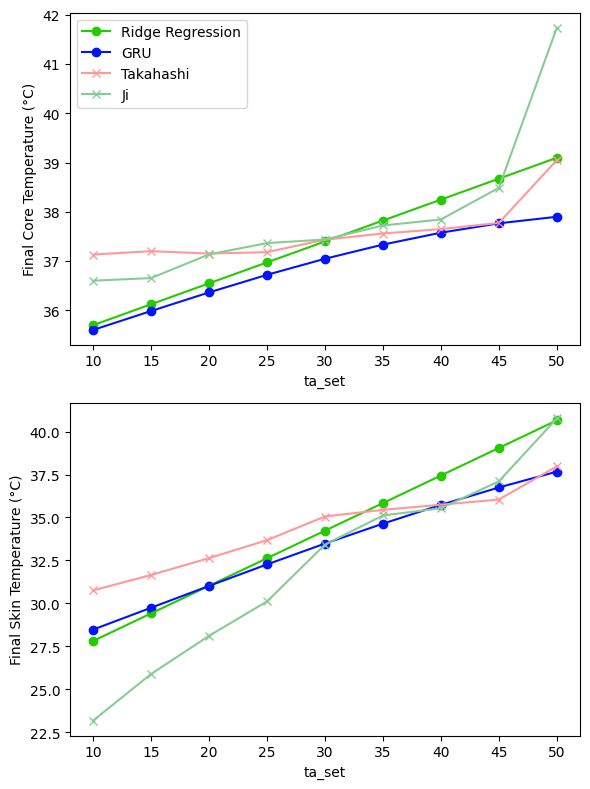

In [90]:
sensitivity_analysis('ta_set', [10, 15, 20, 25, 30, 35, 40, 45, 50], split_subplots=True, connect_dots=True, plot_values=False)

Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
S

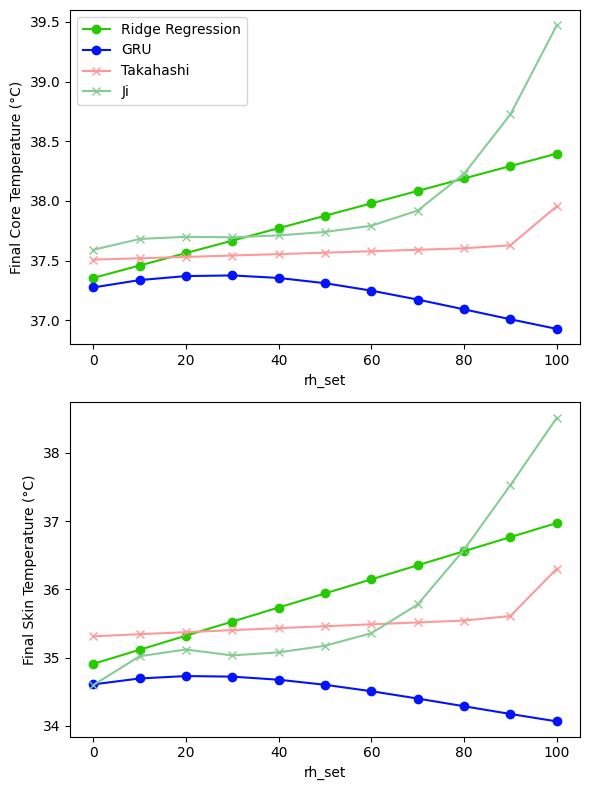

In [91]:
sensitivity_analysis('rh_set', [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], split_subplots=True, connect_dots=True, plot_values=False)